In [20]:
from quasinet.qnet import load_qnet
from quasinet.qnet import qdistance
from quasinet.qsampling import qsample
from quasinet.qnet import membership_degree
import pandas as pd
import numpy as np
from tqdm import tqdm
import pylab as plt
from jupyterthemes import jtplot
jtplot.style()



In [2]:
def dissonance(pos,seq,model):
    if seq[pos]=='':
        return np.nan
    D=model.predict_distributions(seq) 
    return 1-D[pos].get(str(seq[pos]),0)
def dissonance_distr(seq,model):
    return np.array([dissonance(pos,seq,model) for pos in range(len(seq))])

def dissonance_distr_median(seq,model):
    a=dissonance_distr(seq,model)
    return np.median(a[~np.isnan(a)])

# create a naive posstr
def sample_from_pmf(pmf, L):
    """
    Draw L samples from the given PMF.

    :param pmf: A dictionary representing the PMF where keys are outcomes and values are probabilities.
    :param L: The number of samples to draw.
    :return: A list of L samples.
    """
    # Extract the outcomes and their corresponding probabilities
    outcomes = list(pmf.keys())
    probabilities = list(pmf.values())

    # Draw L samples from the outcomes based on the specified probabilities
    samples = np.random.choice(outcomes, size=L, p=probabilities)
    return samples   


In [3]:
pathdata='/home/ishanu/ZED/Research/truthnet/notebooks/data/ptsd/PTSD_cognet_test.csv'
df=pd.read_csv(pathdata,index_col=0)
model_neg=load_qnet('ptsd_neg.pkl.gz',gz=True)
model_pos=load_qnet('ptsd_pos.pkl.gz',gz=True)
INDEX=model_neg.shap_index
featurenames=df.drop('PTSDDx',axis=1).columns

In [76]:
NULLSTR=np.array(['']*len(model_neg.feature_names))
s1=qsample(NULLSTR,model_pos,steps=100000)
s0=qsample(NULLSTR,model_neg,steps=100000)

def func(s,s0,s1,model_pos,model_neg):
    return qdistance(s0,s,model_neg,model_neg)/qdistance(s1,s,model_pos,model_pos)

import random
def funcw(s,model_pos,model_neg,dropone=False,perturb=False,perturbsteps=100):
    if dropone:
        s[random.randint(0, len(s) - 1)] = str(random.randint(1,5))
    if perturb:
        s=qsample(s,model_neg,steps=perturbsteps)
    return membership_degree(s,model_neg)/membership_degree(s,model_pos)

def funcm(array):
    if isinstance(array, np.ndarray):
        if isinstance(array[0], str):
            return -membership_degree(array,model_pos)/(array!='').sum() 
        if isinstance(array[0],np.ndarray):
            if isinstance(array[0][0], str):
                return np.array([-membership_degree(s,model_pos)/(s!='').sum()  for s in array])
    raise('incorrect datatype. must be 2d numpy array of strings')
    return
                
def calcVeritas(s):
    c0,c1=funcm(s),dissonance_distr_median(s,model_pos)#,funcw(POSSTR)
    return (c0>1,c1<0.76)
        

In [12]:
df_test_pos=df.loc[[x for x in df.index.values if x not in model_pos.training_index],:]
df_test_pos=df_test_pos[df_test_pos.PTSDDx==1].drop('PTSDDx',axis=1)
Xpos_test=df_test_pos.values.astype(str)
Xpos_test_incomplete=pd.concat([pd.DataFrame(columns=featurenames),df_test_pos[INDEX[:20]]]).fillna('').values.astype(str)

In [13]:
df_test_neg=df.loc[[x for x in df.index.values if x not in model_neg.training_index],:]
df_test_neg=df_test_neg[df_test_neg.PTSDDx==0].drop('PTSDDx',axis=1)
Xneg_test=df_test_neg.values.astype(str)
Xneg_test_incomplete=pd.concat([pd.DataFrame(columns=featurenames),df_test_neg[INDEX[:20]]]).fillna('').values.astype(str)

In [14]:
Xtest=np.vstack((Xneg_test,Xpos_test))
Xtest_incomplete=np.vstack((Xneg_test_incomplete,Xpos_test_incomplete))
dx=np.append(np.zeros(len(Xneg_test)),np.ones(len(Xpos_test)))

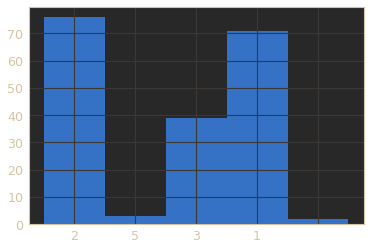

In [175]:
a=[]
[a.extend(x) for x in Xtest]
a=np.array(a)
y=plt.hist(Xtest[13],bins=[.5,1.5,2.5,3.5,4.5,5.5])

In [231]:
import seaborn as sns
mf=pd.concat([pd.DataFrame(pd.DataFrame(x).value_counts()).transpose() for x in Xpos_test_incomplete])
mfn=pd.concat([pd.DataFrame(pd.DataFrame(x).value_counts()).transpose() for x in Xneg_test_incomplete])

In [241]:
mf=mf.drop('',axis=1)/20#.sum(axis=1)
mfn=mfn.drop('',axis=1)/20#.sum(axis=1)


<AxesSubplot:xlabel='0'>

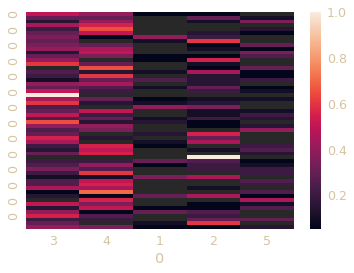

In [243]:
sns.heatmap(mf)
#sns.heatmap(mfn)


In [ ]:
ax=mf.mean().sort_values().plot(kind='bar',alpha=.2,color='r')
mfn.mean().sort_values().plot(kind='bar',ax=ax,alpha=.3,color='g')

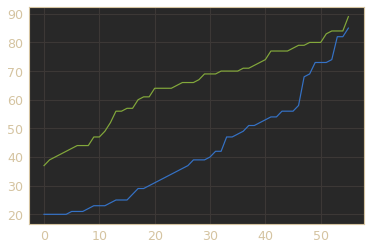

In [269]:
mfc=pd.concat([pd.DataFrame(pd.DataFrame(x).replace('','0').astype(int).sum()).transpose() for x in Xpos_test_incomplete])
b=np.squeeze(mfc.values)
b.sort()
#mfc
mfn=pd.concat([pd.DataFrame(pd.DataFrame(x).replace('','0').astype(int).sum()).transpose() for x in Xneg_test_incomplete])
a=np.squeeze(mfn.values)[np.random.choice(148, 56)]
a.sort()
plt.plot(a)
plt.plot(b)


In [300]:
xx3=np.array(['3']*20)
xx3=pd.concat([pd.DataFrame(columns=featurenames),pd.DataFrame(xx3.reshape(1,-1),columns=INDEX[:20])]).fillna('').values[0].astype(str)

In [301]:
funcm(xx3)

0.9779630917707024

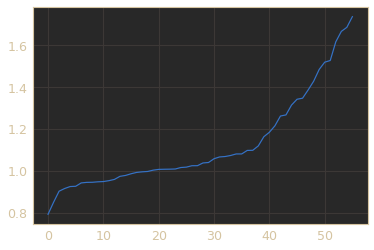

In [305]:
ii=np.array([funcm(i) for i in Xpos_test_incomplete])
ii.sort()
plt.plot(ii)

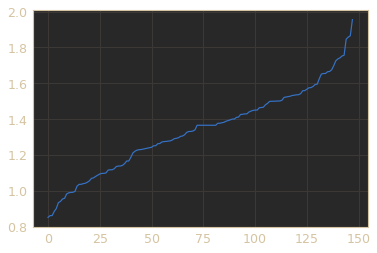

In [306]:
ii=np.array([funcm(i) for i in Xneg_test_incomplete])
ii.sort()
plt.plot(ii)

In [ ]:
np.sort(list(''.join(Xpos_test_incomplete[0])))

In [318]:
def fst(s):
    return ''.join(np.sort(list(s)))

fst('221132')

'112223'

In [341]:
sympos=np.array([fst(''.join(x)) for x in Xpos_test_incomplete])
symneg=np.array([fst(''.join(x)) for x in Xneg_test_incomplete])

sympos


array(['12333333333344444444', '22222233333344444455',
       '22333444444445555555', '33333333344444444444',
       '33334444444444444555', '22233333344444444445',
       '11111111222233333334', '11222222222222333333',
       '23333333444444555555', '22333333334444444445',
       '33344444444445555555', '12333333444444455555',
       '12222222222233333333', '22333333333333444444',
       '24444444444444555555', '11222222222333334445',
       '22233334444444444445', '11111222334444445555',
       '22233333333444444444', '11222222333333444445',
       '22223333333333444455', '33333333333333333333',
       '12233333333344444455', '11222333333333333444',
       '11111111222222233333', '22333333444444444455',
       '22333333333344445555', '11222233333444444555',
       '11123333333333333444', '23333333344444444555',
       '33333444444455555555', '11122222222222333333',
       '22222233333333333444', '11222222222333333333',
       '13333444444444445555', '22333444444444455555',
       '33

In [329]:

sympos.mean(),symneg.mean()

(0.201761325939697, 0.1299046195506894)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [smoothline] >Smoothing by interpolation..
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 85360.9] [loc=0.130 scale=0.050]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 48221.3] [loc=0.111 scale=0.019]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 48221.3] [loc=-8388607.889 scale=8388608.000]
[distfit] >INFO> [dweibull  ] [0.11 sec] [RSS: 53935.2] [loc=0.111 scale=0.045]
[distfit] >INFO> [t         ] [0.15 sec] [RSS: 96199.1] [loc=0.111 scale=0.000]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 96107] [loc=0.111 scale=0.000]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 44171.9] [loc=0.111 scale=0.076]
[distfit] >INFO> [lognorm   ] [0.13 sec] [RSS: 92944.1] [loc=0.111 scale=0.000]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 163538] [loc=0.111 scale=2.071]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 93865.8] [loc=0.111 scale=0.333]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 85716.1] [loc=-17.096 scale=2.274]


(<Figure size 1440x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'\ngamma(a=0.385506, loc=0.111111, scale=0.076101)'}, xlabel='Values', ylabel='Frequency'>)

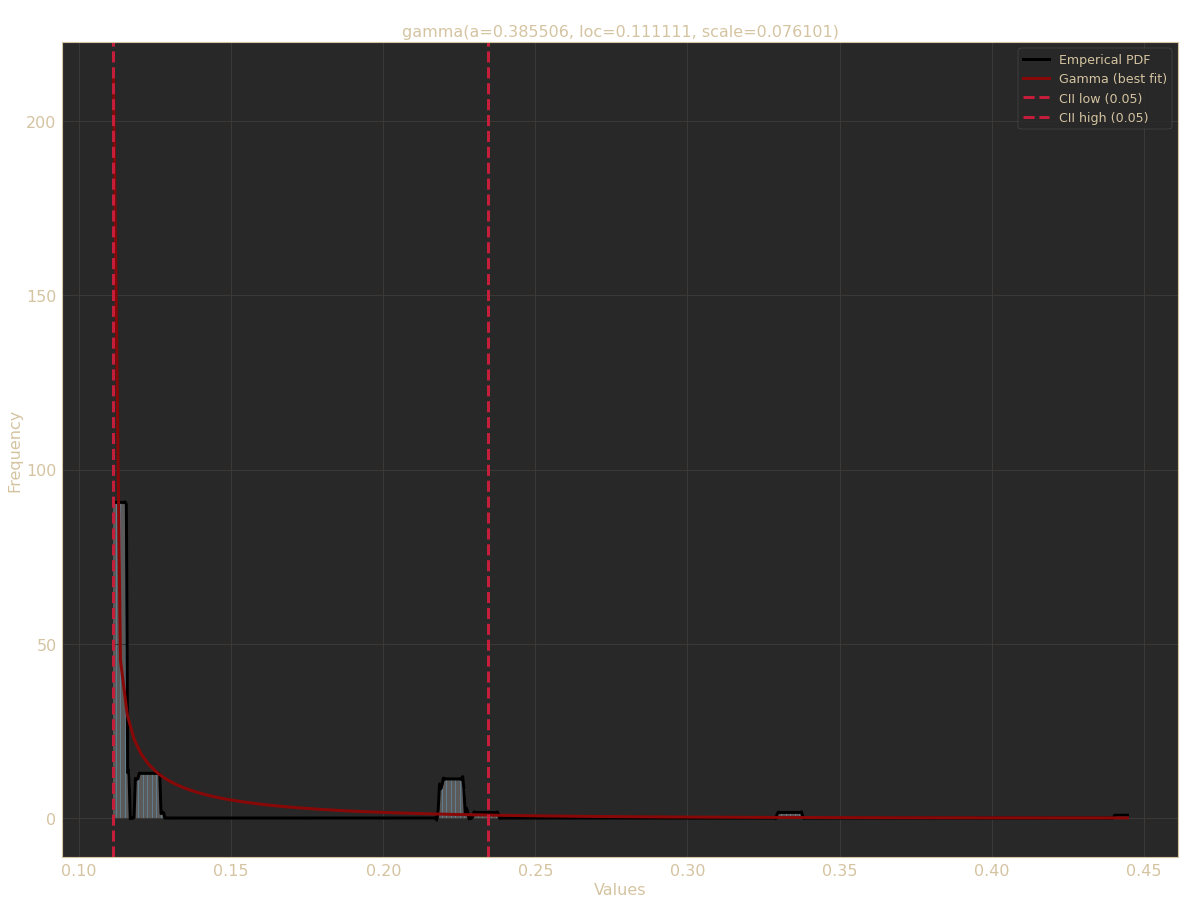

In [334]:
from distfit import distfit
dfit= distfit(smooth=20)
dfit.fit_transform(symneg)
dfit.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [smoothline] >Smoothing by interpolation..
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 893.797] [loc=0.202 scale=0.087]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 860.774] [loc=0.111 scale=0.091]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 865.187] [loc=0.087 scale=0.024]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 873.656] [loc=0.185 scale=0.086]
[distfit] >INFO> [t         ] [0.18 sec] [RSS: 893.799] [loc=0.202 scale=0.087]
[distfit] >INFO> [genextreme] [0.10 sec] [RSS: 902.578] [loc=0.113 scale=0.006]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 882.21] [loc=0.111 scale=0.072]
[distfit] >INFO> [lognorm   ] [0.15 sec] [RSS: 917.255] [loc=0.111 scale=0.181]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 870.287] [loc=0.111 scale=0.361]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 915.418] [loc=0.111 scale=0.333]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 893.712] [loc=-22.113 scale=3.138]
[distfit] >

{'y': array([0.133333]),
 'y_proba': array([0.21740412]),
 'y_pred': array(['none'], dtype='<U4'),
 'P': array([0.21740412]),
 'y_bool': array([False]),
 'df':           y   y_proba y_pred         P
 0  0.133333  0.217404   none  0.217404}

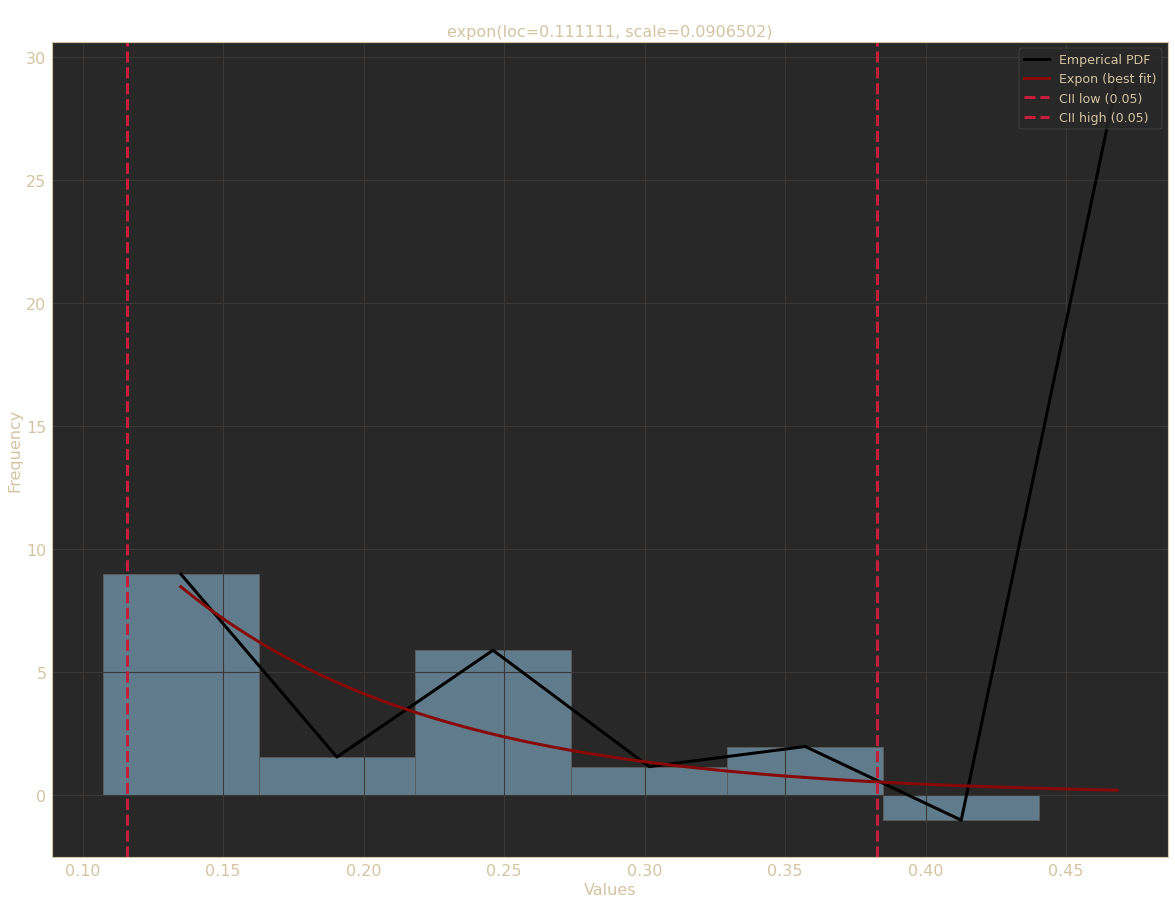

In [339]:
dfit= distfit(smooth=1)
dfit.fit_transform(sympos)
dfit.plot()
dfit.predict(.133333)

In [230]:
mfn.mean().sort_values(), mf.mean().sort_values()

(     0.006757
 2    0.007519
 1    0.007752
 3    0.008850
 4    0.013889
 5    0.025000
 dtype: float64,
      0.017857
 3    0.018868
 4    0.020833
 2    0.022727
 5    0.027778
 1    0.041667
 dtype: float64)

In [144]:
pred = [funcw(qsample(x,model_pos,steps=5),model_pos,model_neg) for x in tqdm(Xtest_incomplete)]


 94%|██████████████████████████████████████▍  | 191/204 [00:11<00:00, 17.60it/s]


100%|█████████████████████████████████████████| 204/204 [00:12<00:00, 16.94it/s]


In [148]:
pred1 = [funcw(qsample(x,model_pos,steps=5),model_pos,model_neg)*func(qsample(x,model_pos,steps=5),s0,s1,model_pos,model_neg) for x in tqdm(Xtest_incomplete)]


 47%|███████████████████▊                      | 96/204 [00:17<00:19,  5.47it/s]


 95%|██████████████████████████████████████▊  | 193/204 [00:33<00:01,  5.63it/s]


100%|█████████████████████████████████████████| 204/204 [00:35<00:00,  5.70it/s]


In [149]:
pred2 = [funcm(qsample(x,model_pos,steps=5)) for x in tqdm(Xtest_incomplete)]


100%|█████████████████████████████████████████| 204/204 [00:05<00:00, 37.92it/s]


In [138]:
predpos = [funcw(qsample(x,model_neg,steps=10),model_pos,model_neg) for x in tqdm(Xpos_test_incomplete)]
predneg = [funcw(qsample(x,model_neg,steps=10),model_pos,model_neg) for x in tqdm(Xneg_test_incomplete)]


100%|███████████████████████████████████████████| 56/56 [00:03<00:00, 15.10it/s]

 91%|█████████████████████████████████████    | 134/148 [00:07<00:00, 17.35it/s]


100%|█████████████████████████████████████████| 148/148 [00:08<00:00, 17.12it/s]


<AxesSubplot:ylabel='Density'>

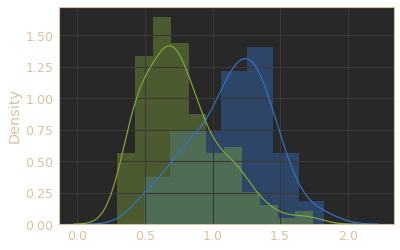

In [139]:
import seaborn as sns
sns.distplot(predpos)
sns.distplot(predneg)


100%|█████████████████████████████████████████| 148/148 [00:16<00:00,  8.78it/s]


<AxesSubplot:ylabel='Density'>

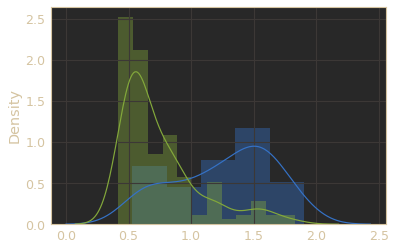

In [88]:
predpos1 = [func(x,s0,s1,model_pos,model_neg) for x in tqdm(Xpos_test)]
predneg1 = [func(x,s0,s1,model_pos,model_neg) for x in tqdm(Xneg_test)]
sns.distplot(predpos1)
sns.distplot(predneg1)


100%|█████████████████████████████████████████| 148/148 [00:03<00:00, 42.66it/s]


<AxesSubplot:ylabel='Density'>

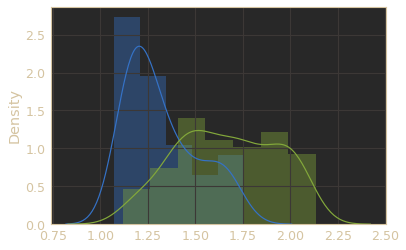

In [94]:
predpos2 = [funcm(x) for x in tqdm(Xpos_test)]
predneg2 = [funcm(x) for x in tqdm(Xneg_test)]
sns.distplot(predpos2)
sns.distplot(predneg2)


In [343]:
predneg2

[1.430701230582499,
 1.3534476057018041,
 1.4234248119587942,
 1.9277554034617017,
 1.4278004296576265,
 1.5164650994411157,
 1.6011454344284821,
 1.204805722066072,
 1.7621920857648994,
 2.007860453408733,
 2.0393391289814433,
 1.4730253152588535,
 1.4848541908955841,
 1.5557845248585698,
 1.6717615329535116,
 1.8655515938368459,
 1.8873207834531092,
 2.017727565478256,
 1.1725954364866813,
 2.0302240916500396,
 1.268136352134364,
 1.3909332580698328,
 1.4500741283388376,
 1.7296731099494163,
 1.5417513290182254,
 1.5683135490736262,
 1.8534441857456319,
 1.9912374225679401,
 1.3439558632273099,
 1.5926824684405438,
 1.310394003700264,
 1.9747753406991448,
 1.7049299604992092,
 1.5153613117689573,
 1.9680726075589148,
 1.596020638614237,
 1.895235720788836,
 1.8912360198402551,
 1.8496409802000366,
 1.3822248993556046,
 1.3382549463663245,
 1.6701758125319655,
 2.0780243615229965,
 2.027396647053701,
 2.0241587217059274,
 1.623334606367503,
 1.3453176891152008,
 1.8000259862271886,
 1

In [150]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(dx, pred1, pos_label=1)
metrics.auc(fpr1, tpr1)

0.8613658301158301

In [151]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(dx, pred2, pos_label=0)
metrics.auc(fpr2, tpr2)

0.7182673745173744

In [152]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(dx, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8432673745173745

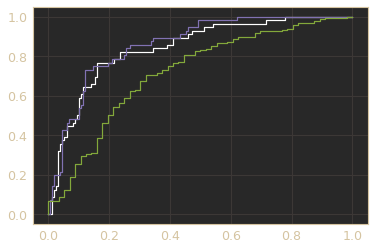

In [153]:
plt.plot(fpr,tpr,'w')
plt.plot(fpr1,tpr1,'m')
plt.plot(fpr2,tpr2,'g')

(0.882705357142857, 0.9213913295105771, 0.8440460612298226)

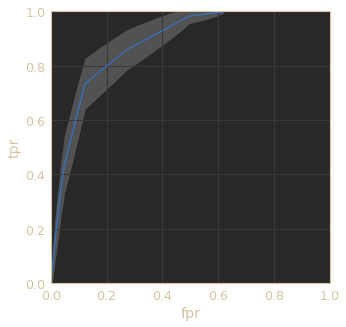

In [154]:
from zedstat import zedstat 
rf2=pd.DataFrame(tpr2,fpr2,columns=['tpr']).assign(threshold=thresholds2)
rf2.index.name='fpr'
rf1=pd.DataFrame(tpr1,fpr1,columns=['tpr']).assign(threshold=thresholds1)
rf1.index.name='fpr'
rf=pd.DataFrame(tpr,fpr,columns=['tpr']).assign(threshold=thresholds)
rf.index.name='fpr'
rf_=pd.concat([rf,rf1]).reset_index()
prev=.5
zt=zedstat.processRoc(df=rf_,
           order=3, 
           total_samples=303,
           positive_samples=150,
           alpha=0.01,
           prevalence=prev)
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=True)
zt.usample(precision=3)
zt.getBounds()
plt.figure(figsize=[5,5])
ax=plt.gca()
ax=zt.get().tpr.plot(ax=ax)
plt.fill_between(x=zt.get().index, y1=zt.df_lim['U'].tpr,y2=zt.df_lim['L'].tpr, color='w',alpha=.2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('tpr');
zt.auc()


In [346]:
zt.scoretoprobability(1.33)

0.8542471042471043

In [155]:
Z=zt.get()
Z[Z.threshold.between(1,1.36)]

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.143,0.750850,0.846346,0.803997,0.775076,5.346892,0.290346,1.352805
0.144,0.751701,0.845920,0.803939,0.775474,5.316303,0.289682,1.345209
0.145,0.752551,0.845493,0.803882,0.775873,5.285714,0.289019,1.337612
0.146,0.753401,0.845066,0.803824,0.776271,5.255126,0.288355,1.330015
0.147,0.754252,0.844639,0.803767,0.776669,5.224537,0.287691,1.322419
...,...,...,...,...,...,...,...
0.356,0.905134,0.752163,0.774629,0.886070,2.718303,0.134135,1.004759
0.357,0.905692,0.751723,0.774410,0.886649,2.713034,0.133419,1.003672
0.358,0.906250,0.751283,0.774192,0.887228,2.707765,0.132702,1.002585


In [44]:
from zedstat.zedstat import score_to_probability

In [57]:
score_to_probability(scores=[1.35],df=Z.reset_index(),prevalence=.5,total_samples=304,positive_samples=86)

[array([0.87, 0.82, 0.92])]

In [46]:
df_test_neg.index.size

148

In [47]:
df_test_pos.index.size

56

In [60]:
se=.668
sp = 1-.103
prevalence=.5
se * prevalence / (se * prevalence + (1 - sp) * (1 - prevalence))

0.8664072632944229

In [77]:
pred1 = [funcw(x,model_pos,model_neg,perturb=True,perturbsteps=200) for x in tqdm(Xtest)]

100%|█████████████████████████████████████████| 204/204 [00:20<00:00,  9.97it/s]


In [78]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(dx, pred1, pos_label=1)
metrics.auc(fpr1, tpr1)

0.8354247104247103

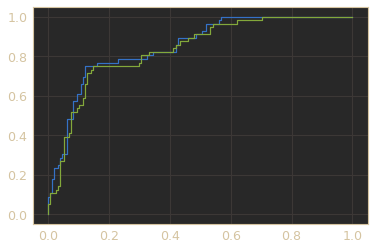

In [79]:
plt.plot(fpr,tpr)
plt.plot(fpr1,tpr1)


(0.8620892857142857, 0.9081614745615487, 0.8160332283617102)

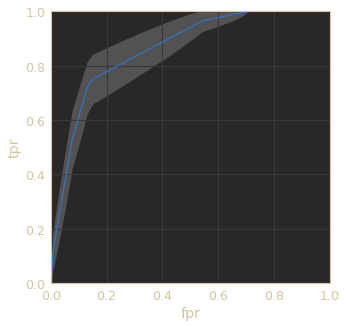

In [80]:
rf1=pd.DataFrame(tpr1,fpr1,columns=['tpr']).assign(threshold=thresholds1)
rf1.index.name='fpr'
rf=pd.DataFrame(tpr,fpr,columns=['tpr']).assign(threshold=thresholds)
rf.index.name='fpr'
#rf_=pd.concat([rf,rfW]).reset_index()
prev=.5
zt=zedstat.processRoc(df=rf1,
           order=3, 
           total_samples=303,
           positive_samples=150,
           alpha=0.01,
           prevalence=prev)
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=True)
zt.usample(precision=3)
zt.getBounds()
plt.figure(figsize=[5,5])
ax=plt.gca()
ax=zt.get().tpr.plot(ax=ax)
plt.fill_between(x=zt.get().index, y1=zt.df_lim['U'].tpr,y2=zt.df_lim['L'].tpr, color='w',alpha=.2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('tpr');
zt.auc()

In [344]:
 ! pwd

/home/ishanu/ZED/Research/truthnet/notebooks/deployment-assets/models/ptsd
